<a href="https://colab.research.google.com/github/raden-dimas012/ImageClassification/blob/main/Fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"radendimas","key":"ccfc55455a7703bfc62bf92efeb5c18e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d moltean/fruits

 98% 741M/760M [00:33<00:01, 18.9MB/s]
100% 760M/760M [00:33<00:00, 24.0MB/s]


In [ ]:
! unzip -q fruits.zip

In [ ]:
!rm fruits.zip

In [ ]:
!mv "/content/fruits-360" "/content/drive/My Drive/final/dataset"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score
from keras.utils import to_categorical
from keras import applications, optimizers

from keras.models import Sequential, Model, load_model,clone_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D 
from keras.losses import categorical_crossentropy

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import applications
from keras.layers import BatchNormalization
from keras.layers import Dropout

from keras.layers import Activation, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [ ]:
print(os.listdir("/content/drive/My Drive/final/dataset/fruits-360/Test"))

['Avocado', 'Banana', 'Apple Red Yellow 2', 'Apple Red Delicious', 'Cherry 2', 'Apple Granny Smith', 'Apple Golden 3', 'Banana Red', 'Avocado ripe', 'Carambula', 'Apple Braeburn', 'Apple Crimson Snow', 'Banana Lady Finger', 'Apricot', 'Cantaloupe 2', 'Beetroot', 'Apple Red 3', 'Apple Red 2', 'Cauliflower', 'Apple Golden 2', 'Cantaloupe 1', 'Apple Golden 1', 'Cactus fruit', 'Apple Pink Lady', 'Cherry 1', 'Cherry Rainier', 'Apple Red 1', 'Blueberry', 'Apple Red Yellow 1', 'Onion Red Peeled', 'Grape Pink', 'Onion White', 'Peach Flat', 'Kohlrabi', 'Limes', 'Grape White 4', 'Ginger Root', 'Maracuja', 'Melon Piel de Sapo', 'Cucumber Ripe 2', 'Mango', 'Grape White', 'Grape White 2', 'Peach 2', 'Papaya', 'Nut Pecan', 'Mangostan', 'Peach', 'Onion Red', 'Eggplant', 'Orange', 'Nectarine', 'Grapefruit White', 'Lemon', 'Guava', 'Clementine', 'Fig', 'Chestnut', 'Mango Red', 'Cherry Wax Black', 'Mandarine', 'Cherry Wax Yellow', 'Grape White 3', 'Lychee', 'Pear 2', 'Grape Blue', 'Granadilla', 'Mulberr

In [ ]:
dataset = "/content/drive/My Drive/final/dataset/fruits-360/"

train = os.path.join(dataset, r'Test')


train_images = sorted(os.listdir(train))
print("Total kategori: ", len(train_images))


Total kategori:  131


In [ ]:
foldernames = os.listdir("/content/drive/My Drive/final/dataset/fruits-360/Test")
categories = []     
files = []           

for k, folder in enumerate(foldernames):
    filenames = os.listdir("/content/drive/My Drive/final/dataset/fruits-360/Test/" + folder);
    for file in filenames:
        files.append("/content/drive/My Drive/final/dataset/fruits-360/Test/" + folder + "/" + file)
        categories.append(k)

df = pd.DataFrame({
    'filename': files,
    'category': categories
})
print("total data : ",df.shape)

print("data yang akan di train adalah :")
train_df = pd.DataFrame(columns=['filename', 'category'])


i = 0
for i in range(20):
    train_df = train_df.append(df[df.category == i].iloc[:140,:])

train_df = train_df.reset_index(drop=True) 
train_df

total data :  (22688, 2)
data yang akan di train adalah :


,filename,category
0,/content/drive/My Drive/final/dataset/fruits-3...,0
1,/content/drive/My Drive/final/dataset/fruits-3...,0
2,/content/drive/My Drive/final/dataset/fruits-3...,0
3,/content/drive/My Drive/final/dataset/fruits-3...,0
4,/content/drive/My Drive/final/dataset/fruits-3...,0
...,...,...
2795,/content/drive/My Drive/final/dataset/fruits-3...,19
2796,/content/drive/My Drive/final/dataset/fruits-3...,19
2797,/content/drive/My Drive/final/dataset/fruits-3...,19
2798,/content/drive/My Drive/final/dataset/fruits-3...,19


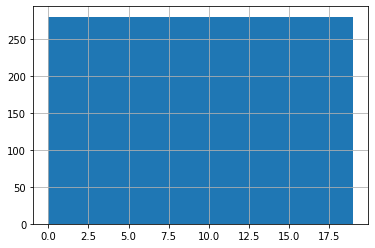

In [ ]:
y = train_df['category']
x = train_df['filename']

x, y = shuffle(x, y, random_state=8)
y.hist()

In [ ]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img 

    return resized

In [ ]:
images = []

with tqdm(total=len(train_df)) as k:  
    for i, file_path in enumerate(train_df.filename.values):
        
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        img = centering_image(cv2.resize(img, dsize=tile_size))
 
        img = img[16:240, 16:240]
        images.append(img)
        k.update(1)

images = np.array(images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


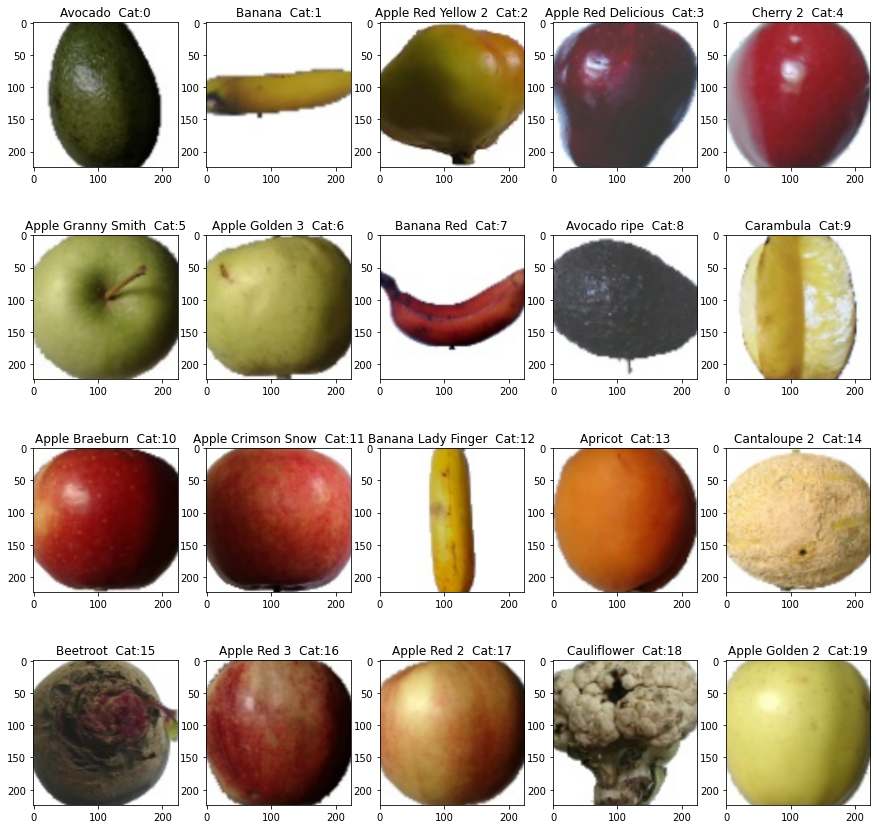

In [ ]:
cols=5
fig, ax = plt.subplots(4,5, figsize=(15,15))
for i in range(20):
    path = train_df[train_df.category == i].values[1] 

    ax[i//cols, i%cols].set_title(path[0].split('/')[-2] +' '+' Cat:'+ str(path[1])) 
    ax[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [ ]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

In [ ]:
val_size = int(round(0.8*len(y)))
x_train = x[:val_size]
y_train = y[:val_size]
x_val = x[val_size:]
y_val = y[val_size:]

print('x_train Shape:', x_train.shape)
print('x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape:',y_val.shape)


y_train = to_categorical(y_train) 
y_val = to_categorical(y_val)


x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255 
x_val /= 255

print('x_train Shape:', x_train.shape)
print('x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape:',y_val.shape)
print('image Shape:', x_train[0].shape)

x_train Shape: (2240, 224, 224, 3)
x_test Shape: (560, 224, 224, 3)
y_train Shape:  (2240,)
y_test Shape: (560,)
x_train Shape: (2240, 224, 224, 3)
x_test Shape: (560, 224, 224, 3)
y_train Shape:  (2240, 20)
y_test Shape: (560, 20)
image Shape: (224, 224, 3)


In [ ]:
name_fruit = []
for i in range(20):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'Avocado':
        name_fruit.append('Alpukat')
    elif path[0].split('/')[-2] == 'Banana':
        name_fruit.append('Pisang')
    elif path[0].split('/')[-2] == 'Apple Red Yellow 2':
        name_fruit.append('Apel Orange')
    elif path[0].split('/')[-2] == 'Apple Red Delicious':
        name_fruit.append('Apel Merah')
    elif path[0].split('/')[-2] == 'Cherry':
        name_fruit.append('Ceri')
    elif path[0].split('/')[-2] == 'Apple Granny Smith':
        name_fruit.append('Apple Hijau')
    elif path[0].split('/')[-2] == 'Apple Golden 3':
        name_fruit.append('Pir')
    elif path[0].split('/')[-2] == 'Banana Red':
        name_fruit.append('Pisang Merah')
    elif path[0].split('/')[-2] == 'Avocado ripe':
        name_fruit.append('Alpukat Matang')
    elif path[0].split('/')[-2] == 'Carambula':
        name_fruit.append('Belimbing')
    elif path[0].split('/')[-2] == 'Apple Braeburn':
        name_fruit.append('Apel Braeburn')
    elif path[0].split('/')[-2] == 'Apple Crimson Snow':
        name_fruit.append('Apel Merah Tua')
    elif path[0].split('/')[-2] == 'Banana Lady Finger':
        name_fruit.append('Pisang Kecil')
    elif path[0].split('/')[-2] == 'Apricot':
        name_fruit.append('Aprikot')
    elif path[0].split('/')[-2] == 'Cantaloupe':
        name_fruit.append('Blewah')
    elif path[0].split('/')[-2] == 'Beetroot':
        name_fruit.append('Ubi Merah')
    elif path[0].split('/')[-2] == 'Apple Red 3':
        name_fruit.append('Apel Merah')
    elif path[0].split('/')[-2] == 'Apple Red 2':
        name_fruit.append('Apel Merah')
    elif path[0].split('/')[-2] == 'Cauliflower':
        name_fruit.append('Kol')
    elif path[0].split('/')[-2] == 'Apple Golden 2':
        name_fruit.append('Pir')

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

base_model1 = applications.VGG16(weights='imagenet', include_top=False,
                                    input_shape=(224,224,3))
model1 = Sequential()
model1.add(Flatten(input_shape= base_model1.output_shape[1:]))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(20, activation='softmax'))

vgg16_model = Model(inputs=base_model1.input,
                        outputs=model1(base_model1.output))

vgg16_model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,metrics=['accuracy'])

vgg16_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [ ]:
train_data_gen = ImageDataGenerator(rotation_range=45, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.2, 
                                    horizontal_flip=True)
train_data_gen.fit(x_train)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-04,
        patience=8,
        verbose=1
    ),
    ModelCheckpoint(
        filepath="vgg16.h5", 
        monitor="val_loss", 
        mode='min', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [ ]:
batch_size =32 
epochs = 30  
history = vgg16_model.fit_generator(train_data_gen.flow(x_train, y_train,
                                        batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,validation_data=(x_val, y_val),
                    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
70/70 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.0585
Epoch 00001: val_loss improved from inf to 0.20019, saving model to vgg16.h5
70/70 [==============================] - 36s 509ms/step - loss: 0.2033 - accuracy: 0.0585 - val_loss: 0.2002 - val_accuracy: 0.0732
Epoch 2/30
70/70 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.0826
Epoch 00002: val_loss improved from 0.20019 to 0.19652, saving model to vgg16.h5
70/70 [==============================] - 35s 500ms/step - loss: 0.1972 - accuracy: 0.0826 - val_loss: 0.1965 - val_accuracy: 0.0946
Epoch 3/30
70/70 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.1076
Epoch 00003: val_loss improved from 0.19652 to 0.19368, saving model to vgg16.h5
70/70 [==============================] - 35s 504ms/step - loss: 0.1944 - accuracy: 0.1076 - val_loss: 0.1937 - val_accuracy: 0.1232
Epoch 4

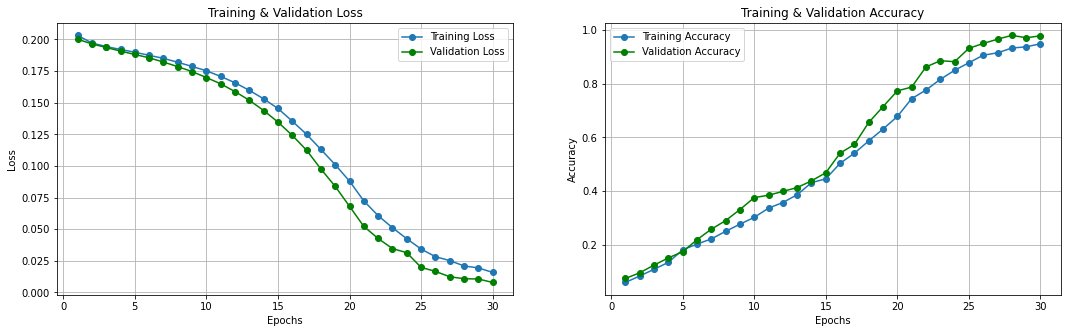

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
epochs = range(1, len(history.history['accuracy'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']

ax[1].plot(epochs, acc_vals, marker='o', label='Training Accuracy')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()
del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [ ]:
score = vgg16_model.evaluate(x_val, y_val, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9785714149475098


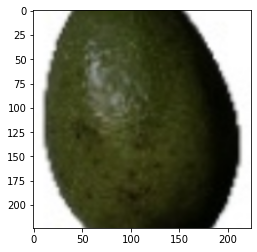

Actual  : Alpukat
Predict : Alpukat


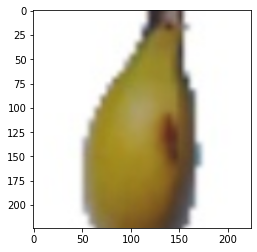

Actual  : Pisang
Predict : Pisang


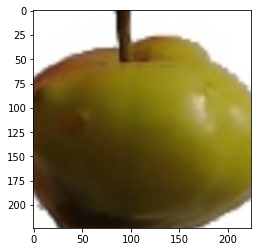

Actual  : Apel Orange
Predict : Apel Braeburn


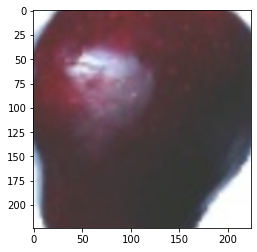

Actual  : Apel Merah
Predict : Apel Merah Tua


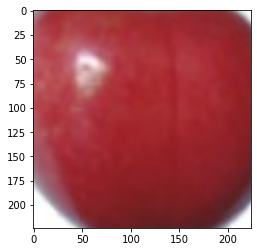

Actual  : Apple Hijau
Predict : Apel Braeburn


In [ ]:
test_images = []
j = 7
for i in range(5):
    path = train_df[train_df.category == i].values[j]
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)
something = vgg16_model.predict(test_images)
fruits = name_fruit
i = 0
for pred in something:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', fruits[i])
    print('Predict :', fruits[np.where(pred.max() == pred)[0][0]])
    i += 1


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(vgg16_model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp4y1j44rj/assets


In [ ]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)